In [1]:
import Spectrogram
from librosa.core import note_to_hz, cqt
from librosa import filters
import numpy as np
import matplotlib.pyplot as plt
from time import time

import torch

# Creating artificial input signal

In [2]:
fs = 22050
s = np.linspace(0,10,fs*10)
x = np.sin(2*np.pi*50*s, dtype=np.float32) + np.sin(2*np.pi*100*s, dtype=np.float32) \
    + np.sin(2*np.pi*200*s, dtype=np.float32) + np.sin(2*np.pi*400*s, dtype=np.float32) \
    + np.sin(2*np.pi*800*s, dtype=np.float32) + np.sin(2*np.pi*1600*s, dtype=np.float32) \
    + np.sin(2*np.pi*3200*s, dtype=np.float32) + np.sin(2*np.pi*6400*s, dtype=np.float32) 

# nnAudio Example

In [3]:
bins = 24 # bins per octave
n_bins = 192
fmin = note_to_hz('C1')
stride = 512

## 1992 implmentation

In [4]:
# Initializing conv1d for CQT 1992 version
CQT_layer = Spectrogram.CQT1992(fs, stride, fmin, fmax=None, n_bins=n_bins,
                        bins_per_octave=bins, norm=None,center=True,
                        pad_mode='reflect')

CQT kernels created, time used = 0.4396 seconds
STFT kernels created, time used = 51.5675 seconds


## 2010 implmentation

In [5]:
# Initializing conv1d for CQT 2010 version
CQT_layer2 = Spectrogram.CQT2010(fs, stride, fmin, fmax=None, n_bins=n_bins,
                        bins_per_octave=bins,
                        pad_mode='reflect', earlydownsample=False)


CQT kernels created, time used = 0.0052 seconds
STFT kernels created, time used = 0.0062 seconds


In [6]:
cqt_torch = CQT_layer(torch.tensor(x))

In [7]:
cqt_torch2 = CQT_layer2(torch.tensor(x))

Text(0.5, 1.0, '2010 version')

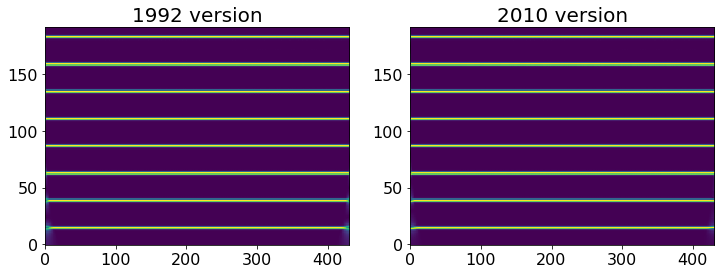

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].imshow(cqt_torch[0].numpy(),aspect='auto', origin='lower')
ax[0].tick_params(labelsize=16)
ax[0].set_title('1992 version', size=20)

ax[1].imshow(cqt_torch2[0].numpy(), aspect='auto', origin='lower')
ax[1].tick_params(labelsize=16)
ax[1].set_title('2010 version', size=20)

## Checking if the two implementations are the same

Text(0.5, 1.0, 'Spectrum at time slice 29')

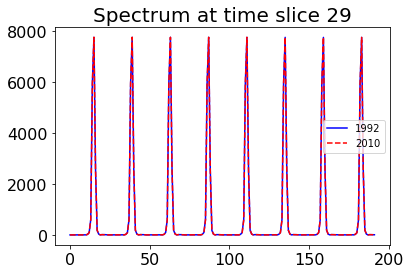

In [9]:
plt.plot(cqt_torch[0].numpy()[:,29], 'b')
plt.plot(cqt_torch2[0].numpy()[:,29], 'r--')
plt.legend(['1992', '2010'])
plt.tick_params(labelsize=16)
plt.title("Spectrum at time slice 29", size=20)

# Librosa

In [10]:
from librosa.core import cqt

In [11]:
cqt_lib = cqt(x, fs, stride, fmin, n_bins=n_bins,
              bins_per_octave=bins)

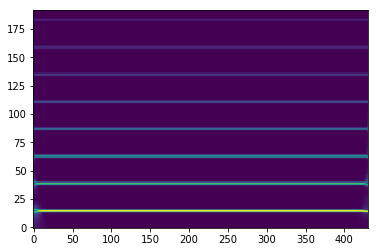

In [12]:
plt.imshow(abs(cqt_lib),aspect='auto', origin='lower')

## Comparing nnAudio and Librosa output

Text(0.5, 1.0, 'Spectrum at time slice 29')

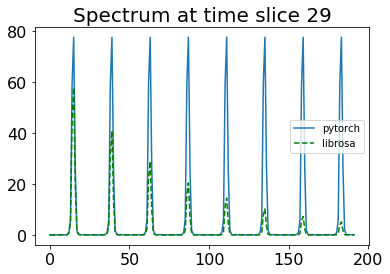

In [13]:
plt.plot(cqt_torch[0].numpy()[:,29]/100)
plt.plot(abs(cqt_lib[:,29]), 'g--')
plt.legend(['pytorch', 'librosa'])
plt.tick_params(labelsize=16)
plt.title("Spectrum at time slice 29", size=20)